In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
import os

pre_file_path = os.path.join('preprocessed', 'pre-processed.csv')
pre_df = pd.read_csv(pre_file_path, index_col= 0)
pre_df.index.name = None
pre_df = pre_df.rename(columns={"preprocessed_news": "text"})
pre_df = pre_df[["text","label"]]
pre_df

,text,label
0,katia abreu diz vai colocar expulsao moldura n...,fake
1,ray peita bolsonaro conservador fake entrevist...,fake
2,reinaldo azevedo desmascarado policia federal ...,fake
3,relatorio assustador bndes mostra dinheiro pub...,fake
4,radialista americano fala sobre pt vendem ilus...,fake
...,...,...
7195,jornal britanico acao contra lula lava jato se...,true
7196,temer diz acionou pf cade investigar aumentos ...,true
7197,obstaculos politicos temer especialistas ouvid...,true
7198,setembro boa noite aqui estao principais notic...,true


In [3]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(pre_df["text"], pre_df["label"], shuffle= True, test_size=0.2)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

bag_of_words = CountVectorizer()
bag_of_words.fit(X_train)

In [5]:
list(bag_of_words.vocabulary_.items())[:10]

[('reformas', 58571),
 ('privatizacoes', 55217),
 ('devem', 22332),
 ('ser', 63187),
 ('feitas', 30451),
 ('ja', 39918),
 ('ano', 4076),
 ('governo', 33804),
 ('diz', 23523),
 ('arida', 5492)]

In [6]:
X_train = bag_of_words.transform(X_train).toarray()
X_test = bag_of_words.transform(X_test).toarray()

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

GNB = GaussianNB()
BNB = BernoulliNB()
MNB = MultinomialNB()


naive_bayes = [GNB, BNB, MNB]
naive_bayes_names = ["GNB", "BNB", "MNB"]

In [8]:
from sklearn.model_selection import cross_val_score

for i, algo in enumerate(naive_bayes):
    acc = cross_val_score(algo, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{algo} mean accuracy: ", end = "")
    print(round(np.mean(acc), 3))

GaussianNB() mean accuracy: 0.617
BernoulliNB() mean accuracy: 0.915
MultinomialNB() mean accuracy: 0.826


In [9]:
from collections import defaultdict
scores = defaultdict(list)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

for algo in naive_bayes:
    algo.fit(X_train, y_train)
    y_predict = algo.predict(X_test)

    scores["accuracy"].append(accuracy_score(y_test, y_predict))
    scores["precision"].append(precision_score(y_test, y_predict, pos_label = 'fake'))
    scores["recall"].append(recall_score(y_test, y_predict, pos_label = 'fake'))
    scores["f1_score"].append(f1_score(y_test, y_predict, pos_label = 'fake'))

naive_results_df = pd.DataFrame(scores, index = naive_bayes_names)
naive_results_df

,accuracy,precision,recall,f1_score
GNB,0.606250,0.953757,0.227901,0.367893
BNB,0.915972,0.869033,0.980663,0.921480
MNB,0.818056,0.962000,0.664365,0.785948


In [10]:
# from sklearn.model_selection import GridSearchCV

# num_target_classes = 2

# params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
#           'fit_prior': [True, False],
#           'class_prior': [None, [0.1,]* num_target_classes, ],
#           'binarize': [None, 0.0, 8.5, 10.0]
#          }

# bernoulli_nb_grid = GridSearchCV(BernoulliNB(), param_grid=params, n_jobs=-1, cv=5)
# bernoulli_nb_grid.fit(X_train,y_train)
# bernoulli_nb_grid.best_params_

In [11]:
# best_acc_model_param = bernoulli_nb_grid.best_params_
best_bernoulli_param = {'alpha': 0.01, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}
best_bernoulli = BernoulliNB(**best_bernoulli_param)

#{'alpha': 0.01, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}

In [12]:
best_bernoulli.fit(X_train, y_train)
y_predict = best_bernoulli.predict(X_test)

acc = accuracy_score(y_test, y_predict)
prec = precision_score(y_test, y_predict, pos_label = 'fake')
recall = recall_score(y_test, y_predict, pos_label = 'fake')
f1 = f1_score(y_test, y_predict, pos_label = 'fake')

naive_results_df.loc["Tuned BNB"] = [acc, prec, recall, f1]
naive_results_df

,accuracy,precision,recall,f1_score
GNB,0.606250,0.953757,0.227901,0.367893
BNB,0.915972,0.869033,0.980663,0.921480
MNB,0.818056,0.962000,0.664365,0.785948
Tuned BNB,0.935417,0.909209,0.968232,0.937793


[]

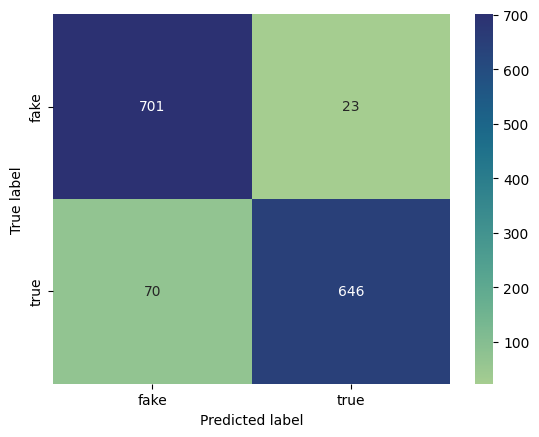

In [13]:
from sklearn.metrics import confusion_matrix

labels = ["fake","true"]
s = sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt="g", xticklabels=labels, yticklabels=labels, cmap="crest")
s.set_xlabel("Predicted label")
s.set_ylabel("True label")
s.set_title("Confusion matrix")
s.plot()